In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as stats
import math
import statsmodels.api as sm
import pylab
%matplotlib inline
from datetime import datetime

from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt

/Applications/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Applications/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_sample = pd.read_csv('sample_submission.csv')
dfr = pd.read_csv('fastest_routes_train_part_1.csv', usecols=['id','total_distance','total_travel_time','number_of_steps'])
dfr1 = pd.read_csv('fastest_routes_test.csv', usecols=['id','total_distance','total_travel_time','number_of_steps'])
df_route = pd.concat((dfr,dfr1))

# Clean Up the Data

In [3]:
df_route.head()

,id,total_distance,total_travel_time,number_of_steps
0,id2875421,2009.1,164.9,5
1,id2377394,2513.2,332.0,6
2,id3504673,1779.4,235.8,4
3,id2181028,1614.9,140.1,5
4,id0801584,1393.5,189.4,5


In [4]:
df_train=df_train.merge(df_route,how='left',on='id')

In [156]:
df_test=df_test.merge(df_route,how='left',on='id')

In [5]:
df_train['total_distance'].fillna(df_train['total_distance'].mean(),inplace=True)
df_train['total_travel_time'].fillna(df_train['total_travel_time'].mean(),inplace=True)
df_train['number_of_steps'].fillna(df_train['number_of_steps'].mean(),inplace=True)
None

In [157]:
df_test['total_distance'].fillna(df_test['total_distance'].mean(),inplace=True)
df_test['total_travel_time'].fillna(df_test['total_travel_time'].mean(),inplace=True)
df_test['number_of_steps'].fillna(df_test['number_of_steps'].mean(),inplace=True)
None

In [6]:
#remove trips with passengers >6 and outside 3std of the mean
df_train = df_train[df_train['passenger_count']<=6]
m = np.mean(df_train['trip_duration'])
s = np.std(df_train['trip_duration'])
df_train = df_train[df_train['trip_duration'] <= m + 3*s]
df_train = df_train[df_train['trip_duration'] >= m - 3*s]

In [7]:
(m+3*s)/3600
#max trip duration of <5hrs

4.631058635614501

(0, 6000)

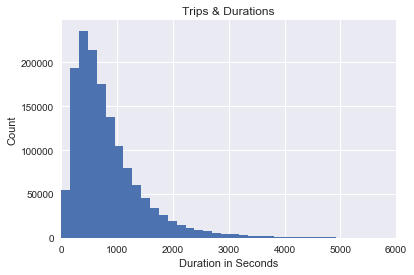

In [8]:
df_train.trip_duration.hist(bins=100)
plt.title('Trips & Durations')
plt.ylabel('Count')
plt.xlabel('Duration in Seconds')
plt.xlim((0,6000))

(0, 10)

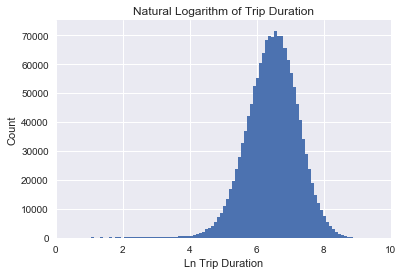

In [272]:
df_train['log_trip_duration'] = np.log(df_train['trip_duration'].values+1)
df_train['log_trip_duration'].plot.hist(bins=100)
plt.title('Natural Logarithm of Trip Duration')
plt.xlabel('Ln Trip Duration')
plt.ylabel('Count')
plt.xlim(0,10)

In [10]:
df_train['trip_duration'].max()/3600

4.416666666666667

In [11]:
np.log(834)

6.7262334023587469

In [274]:
df_train['trip_duration'].describe()

count    1.456566e+06
mean     8.371205e+02
std      6.613654e+02
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.073000e+03
max      1.590000e+04
Name: trip_duration, dtype: float64

In [13]:
#conversions to datetime and check the conversion worked well
df_train['pickup_datetime'] = pd.to_datetime(df_train.pickup_datetime)
df_test['pickup_datetime'] = pd.to_datetime(df_test.pickup_datetime)
df_train.loc[:, 'pickup_date'] = df_train['pickup_datetime'].dt.date
df_test.loc[:, 'pickup_date'] = df_test['pickup_datetime'].dt.date
df_train['dropoff_datetime'] = pd.to_datetime(df_train.dropoff_datetime)
df_train['store_and_fwd_flag'] = 1 * (df_train.store_and_fwd_flag.values == 'Y')
df_test['store_and_fwd_flag'] = 1 * (df_test.store_and_fwd_flag.values == 'Y')
df_train['check_trip_duration'] = (df_train['dropoff_datetime'] - df_train['pickup_datetime']).map(lambda x: x.total_seconds())
duration_difference = df_train[np.abs(df_train['check_trip_duration'].values  - df_train['trip_duration'].values) > 1]
print('Trip_duration and datetimes are ok.') if len(duration_difference[['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration']]) == 0 else print('Ooops.')

Trip_duration and datetimes are ok.


In [159]:
df_test['dropoff_datetime'] = pd.to_datetime(df_test.pickup_datetime)
df_test['dropoff_datetime'] = pd.to_datetime(df_test.dropoff_datetime)

In [160]:
#add datetime versions of the original time stamps
df_train.loc[:, 'pickup_weekday'] = df_train['pickup_datetime'].dt.weekday
df_train.loc[:, 'pickup_hour_weekofyear'] = df_train['pickup_datetime'].dt.weekofyear
df_train.loc[:, 'pickup_hour'] = df_train['pickup_datetime'].dt.hour
df_train.loc[:, 'pickup_minute'] = df_train['pickup_datetime'].dt.minute
df_train.loc[:, 'pickup_dt'] = (df_train['pickup_datetime'] - df_train['pickup_datetime'].min()).dt.total_seconds()
df_train.loc[:, 'pickup_week_hour'] = df_train['pickup_weekday'] * 24 + df_train['pickup_hour']
df_test.loc[:, 'pickup_weekday'] = df_test['pickup_datetime'].dt.weekday
df_test.loc[:, 'pickup_hour_weekofyear'] = df_test['pickup_datetime'].dt.weekofyear
df_test.loc[:, 'pickup_hour'] = df_test['pickup_datetime'].dt.hour
df_test.loc[:, 'pickup_minute'] = df_test['pickup_datetime'].dt.minute
df_test.loc[:, 'pickup_dt'] = (df_test['pickup_datetime'] - df_test['pickup_datetime'].min()).dt.total_seconds()
df_test.loc[:, 'pickup_week_hour'] = df_test['pickup_weekday'] * 24 + df_test['pickup_hour']
df_train['Month'] = df_train['pickup_datetime'].dt.month
df_test['Month'] = df_test['pickup_datetime'].dt.month

# Start Exploring

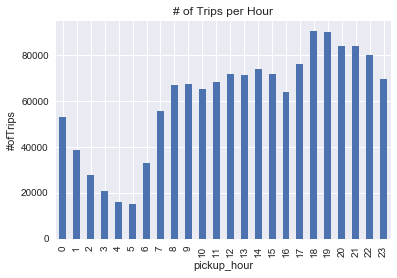

In [15]:
df_train.groupby(['pickup_hour']).size().plot.bar()
plt.title('# of Trips per Hour')
plt.ylabel('#ofTrips')
#number of trips each hour, peaking around dinner time

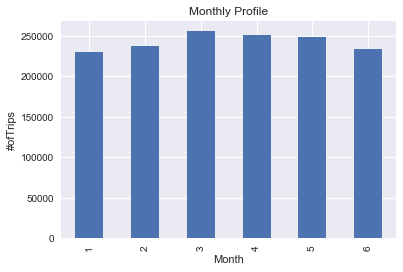

In [140]:
df_train.groupby(['Month']).size().plot.bar()
plt.ylabel('#ofTrips')
plt.title('Monthly Profile')
#strange that data is only 6 months of the year???

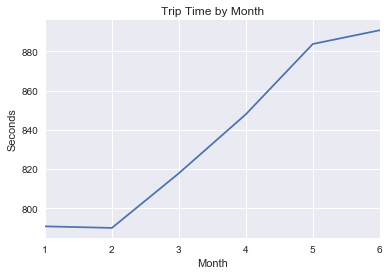

In [17]:
df_train.groupby(['Month'])['trip_duration'].mean().plot.line()
plt.title('Trip Time by Month')
plt.ylabel('Seconds')
#do the trip times increase as a result of summer?

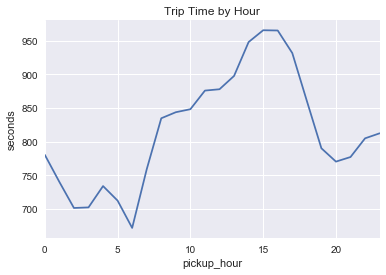

In [18]:
df_train.groupby(['pickup_hour'])['trip_duration'].mean().plot.line()
plt.ylabel('seconds')
plt.title('Trip Time by Hour')
#do the trip times increase as a result of rush hour? not really it seems there is a big peak at 3pm
#lulls in ridership in early morning and around 8pm

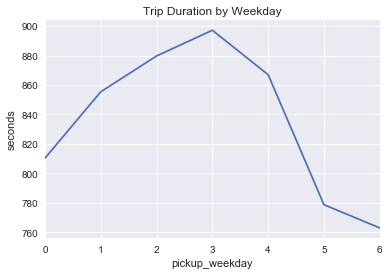

In [19]:
df_train.groupby(['pickup_weekday'])['trip_duration'].mean().plot.line()
plt.ylabel('seconds')
plt.title('Trip Duration by Weekday')
#peak traffic on wednesdays

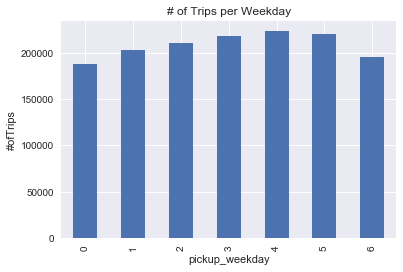

In [141]:
df_train.groupby(['pickup_weekday']).size().plot.bar()
plt.title('# of Trips per Weekday')
plt.ylabel('#ofTrips')

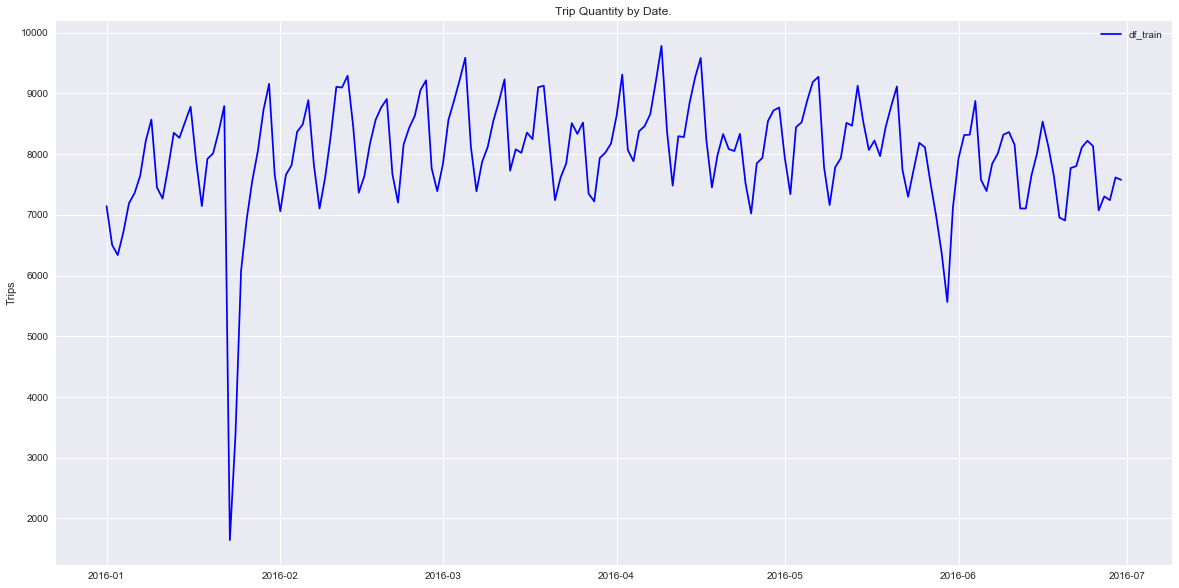

In [21]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(df_train.groupby('pickup_date').count()[['id']], 'b-', label='df_train')
plt.title('Trip Quantity by Date.')
plt.legend(loc=0)
plt.ylabel('Trips')
plt.show()

#the number of trips dropped massively due to a huge snow storm that hit the NYC area in early 2016

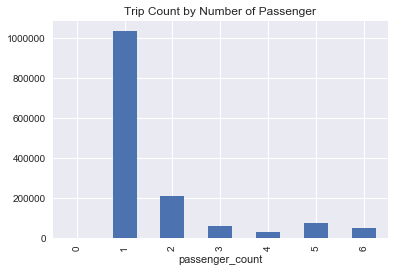

In [22]:
df_train.groupby(['passenger_count']).size().plot.bar()
plt.title('Trip Count by Number of Passenger')

In [23]:
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,log_trip_duration,pickup_date,check_trip_duration,pickup_weekday,pickup_hour_weekofyear,pickup_hour,pickup_minute,pickup_dt,pickup_week_hour,Month
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,...,6.122493,2016-03-14,455.0,0,11,17,24,6369878.0,17,3
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,...,6.498282,2016-06-12,663.0,6,23,0,43,14085798.0,144,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,...,7.661527,2016-01-19,2124.0,1,3,11,35,1596907.0,35,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,...,6.063785,2016-04-06,429.0,2,14,19,32,8364734.0,67,4
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,...,6.077642,2016-03-26,435.0,5,12,13,30,7392638.0,133,3


In [24]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456566 entries, 0 to 1458643
Data columns (total 24 columns):
id                        1456566 non-null object
vendor_id                 1456566 non-null int64
pickup_datetime           1456566 non-null datetime64[ns]
dropoff_datetime          1456566 non-null datetime64[ns]
passenger_count           1456566 non-null int64
pickup_longitude          1456566 non-null float64
pickup_latitude           1456566 non-null float64
dropoff_longitude         1456566 non-null float64
dropoff_latitude          1456566 non-null float64
store_and_fwd_flag        1456566 non-null int64
trip_duration             1456566 non-null int64
total_distance            1456566 non-null float64
total_travel_time         1456566 non-null float64
number_of_steps           1456566 non-null float64
log_trip_duration         1456566 non-null float64
pickup_date               1456566 non-null object
check_trip_duration       1456566 non-null float64
pickup_weekday  

In [25]:
df_train['passenger_count'].describe()

count    1.456566e+06
mean     1.663924e+00
std      1.313574e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      6.000000e+00
Name: passenger_count, dtype: float64

Explore the following using hypothesis testing or correlations:
 1. Is there a statistical difference between the taxi vendors trip durations?
 - trip duration vs passenger count
 - trip duration vs time of year (seasonal, i.e. summer/winter)
 - impact of rush hour on trip duration
 - demonstrate the trip durations to airports is related to the pickup distance from the airport
 - trip duration vs total distance (need to import the OCRM data)
 
 
 Cleaning Data:
 - remove the super long trips: set limit to 3 standard deviations from mean
 - remove the trips with >5 passengers : removed all trips with passengers >6
 - remove trips that have zero distance and greater than 5 minutes  <<<don't know how to do yet>>>

(600, 900)

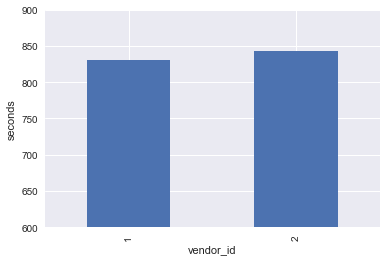

In [139]:
df_train.groupby(['vendor_id'])['trip_duration'].mean().plot.bar()
plt.ylabel('seconds')
plt.ylim((600,900))

In [275]:
vendor1_df = df_train[df_train['vendor_id']==1]
vendor2_df = df_train[df_train['vendor_id']==2]

trip = df_train.as_matrix(columns=['trip_duration'])

vendor1_trip = vendor1_df.as_matrix(columns=['trip_duration'])
vendor2_trip = vendor2_df.as_matrix(columns=['trip_duration'])

mu_vendor1 = np.mean(vendor1_trip)
sig_vendor1 = np.std(vendor1_trip)

mu_vendor2 = np.mean(vendor2_trip)
sig_vendor2 = np.std(vendor2_trip)

mu_trip = np.mean(trip)
sig_trip = np.std(trip)

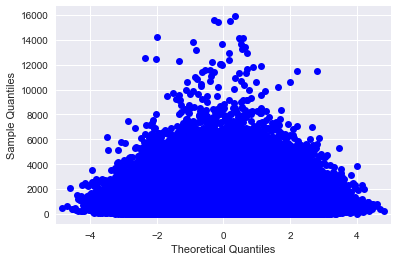

In [28]:
sm.qqplot(trip)
pylab.show()

In [29]:
stats.mstats.normaltest(trip)

NormaltestResult(statistic=masked_array(data = [810422.2242228067],
             mask = [False],
       fill_value = 1e+20)
, pvalue=array([ 0.]))

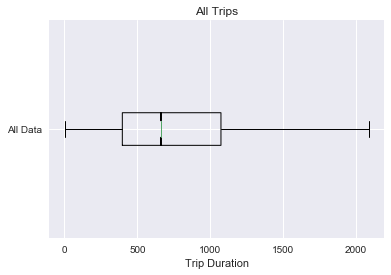

In [276]:
plt.figure()
plt.boxplot([trip],1 ,'rs',0, labels=['All Data'],showfliers=False)
plt.xlabel('Trip Duration')
plt.title('All Trips')
None

In [31]:
df_train.groupby(['vendor_id'])['id'].count()
#huge sample, probably will use z-stat assuming it is representative of the population standard deviation

vendor_id
1    678333
2    778233
Name: id, dtype: int64

In [32]:
def get_z(sample1, sample2):
    z = (np.mean(sample1) - np.mean(sample2)) / math.sqrt(np.std(sample1)**2/len(sample1)+np.std(sample2)**2/len(sample2))
    return z


def get_t(sample, null_hypo):
    t = (np.mean(sample) - null_hypo) / (np.std(sample) / math.sqrt(len(sample)))
    return t

In [33]:
z = get_z(vendor1_trip, vendor2_trip)
print('Z statastic:', z)
#makes it very unlikely that the means are statistically equal, null hypothesis will be rejected

Z statastic: -10.7069562755


Ho: mu1 - mu2 = deltao
Ha: mu1 - mu2 < deltao

This is to say that for Ha, the mean trip duration of vendor 1 is less than mean trip duration of vendor 2. This inequality indicates a lower tailed test where we reject the null hypothesis if z<= -zalpha

For an alpha value of 0.95 the Zcritical value is 1.65 meaning that in order to reject the null hypothesis our calculated statistic has to be z<= -1.65.

In this case our z statistic is -10.7 which is less than -1.65 and so we must reject the null hypothesis that the mean trip durations are equal and accept that vendor 1 has a lower mean trip duration than vendor 2.

The P-value is also 0 meaning Ho should be rejected for any reasonable significance level.

It is also fair to say that although the means are different, they are not different by much and this will likely not be a significant factor in determining trip duration.

# Series of Box Plots

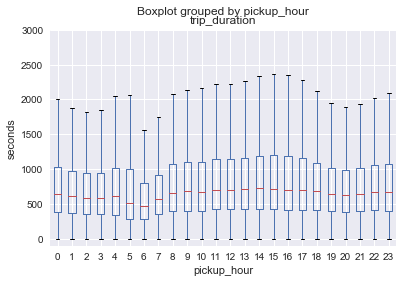

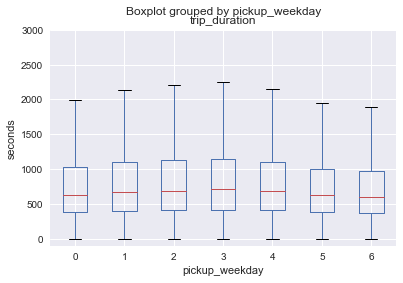

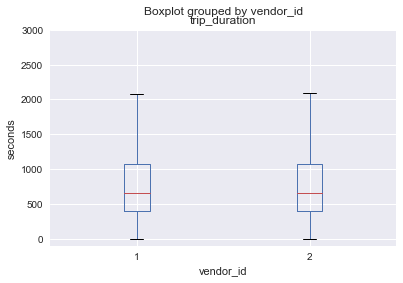

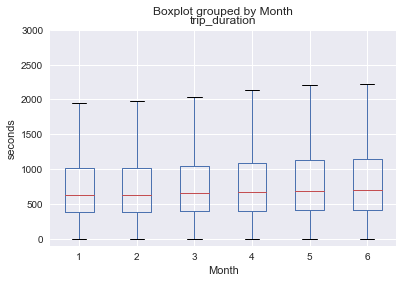

In [34]:
#how do i use matplotlib axis objects?
ax=df_train.boxplot(column='trip_duration',by='pickup_hour')
ax.set_ylim(-100,3000)
ax.set_ylabel ('seconds')

ax1=df_train.boxplot(column='trip_duration',by='pickup_weekday')
ax1.set_ylim(-100,3000)
ax1.set_ylabel ('seconds')

ax2=df_train.boxplot(column='trip_duration',by='vendor_id')
ax2.set_ylim(-100,3000)
ax2.set_ylabel ('seconds')

ax3=df_train.boxplot(column='trip_duration',by='Month')
ax3.set_ylim(-100,3000)
ax3.set_ylabel ('seconds')

# Test for Correlation Between Trip Duration & Passenger Count

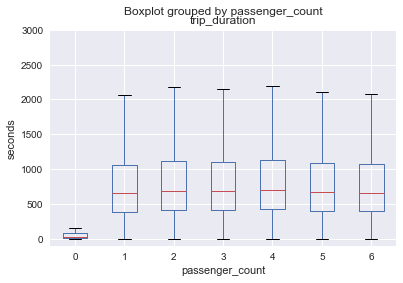

In [35]:
ax4=df_train.boxplot(column='trip_duration',by='passenger_count')
ax4.set_ylim(-100,3000)
ax4.set_ylabel('seconds')

# Lets add in the direct distance formulas & calculate average speed

In [36]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [37]:
df_train.loc[:, 'distance_haversine'] = haversine_array(df_train['pickup_latitude'].values, df_train['pickup_longitude'].values, df_train['dropoff_latitude'].values, df_train['dropoff_longitude'].values)
    
df_train.loc[:, 'direction'] = bearing_array(df_train['pickup_latitude'].values, df_train['pickup_longitude'].values, df_train['dropoff_latitude'].values, df_train['dropoff_longitude'].values)

df_train.loc[:, 'speed'] = 1000*df_train['distance_haversine']/df_train['trip_duration']

In [163]:
df_test.loc[:, 'distance_haversine'] = haversine_array(df_test['pickup_latitude'].values, df_test['pickup_longitude'].values, df_test['dropoff_latitude'].values, df_test['dropoff_longitude'].values)
    
df_test.loc[:, 'direction'] = bearing_array(df_test['pickup_latitude'].values, df_test['pickup_longitude'].values, df_test['dropoff_latitude'].values, df_test['dropoff_longitude'].values)


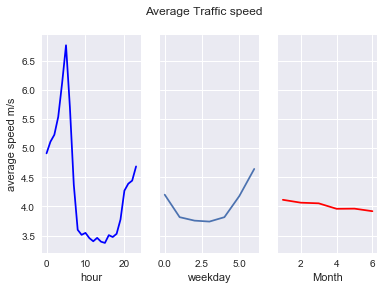

In [145]:
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(df_train.groupby('pickup_hour')['speed'].mean(),'b-')
ax[1].plot(df_train.groupby('pickup_weekday')['speed'].mean())
ax[2].plot(df_train.groupby('Month')['speed'].mean(), 'r-')
ax[0].set_xlabel('hour')
ax[1].set_xlabel('weekday')
ax[2].set_xlabel('Month')
ax[0].set_ylabel('average speed m/s')
fig.suptitle('Average Traffic speed')
plt.show()

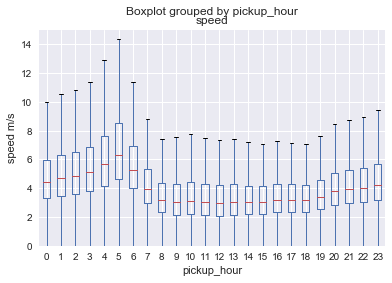

In [151]:
df_train.boxplot(column='speed',by='pickup_hour')
plt.ylim(0,15)
plt.ylabel('speed m/s')

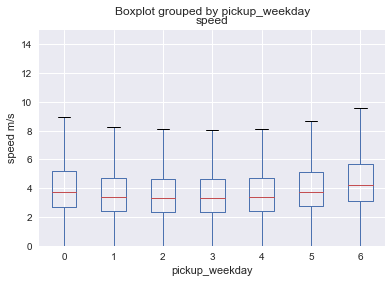

In [152]:
df_train.boxplot(column='speed',by='pickup_weekday')
plt.ylim(0,15)
plt.ylabel('speed m/s')

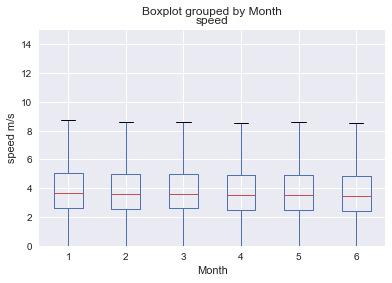

In [153]:
df_train.boxplot(column='speed',by='Month')
plt.ylim(0,15)
plt.ylabel('speed m/s')

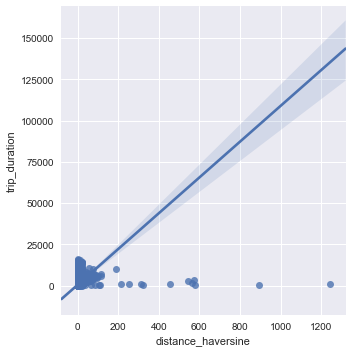

In [39]:
lm = sns.lmplot(x='distance_haversine',y='trip_duration',data=df_train)

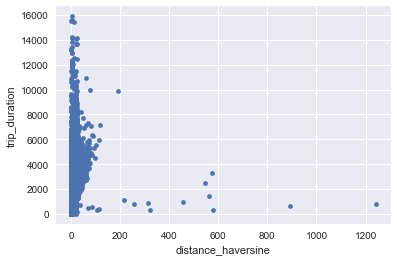

In [40]:
df_train.plot.scatter(x='distance_haversine',y='trip_duration')
#plt.ylim(0,2000)
#plt.xlim(0,25)

# Lets incorporate the Neighbourhoods via K-Means Clustering

In [82]:
coords = np.vstack((df_train[['pickup_latitude', 'pickup_longitude']].values,
                    df_train[['dropoff_latitude', 'dropoff_longitude']].values,
                    df_test[['pickup_latitude', 'pickup_longitude']].values,
                    df_test[['dropoff_latitude', 'dropoff_longitude']].values))
coords_duration = np.vstack((df_train[['distance_haversine','log_trip_duration']].values))

In [99]:
sample_ind = np.random.permutation(len(coords))[:500000]
sample_dur = np.random.permutation(len(coords_duration))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])
kmeansdur = MiniBatchKMeans(n_clusters=4).fit(coords_duration[sample_dur])

In [165]:
t0 = datetime.now()
df_train.loc[:, 'pickup_cluster'] = kmeans.predict(df_train[['pickup_latitude', 'pickup_longitude']])
df_train.loc[:, 'dropoff_cluster'] = kmeans.predict(df_train[['dropoff_latitude', 'dropoff_longitude']])
df_test.loc[:, 'pickup_cluster'] = kmeans.predict(df_test[['pickup_latitude', 'pickup_longitude']])
df_test.loc[:, 'dropoff_cluster'] = kmeans.predict(df_test[['dropoff_latitude', 'dropoff_longitude']])
df_train.loc[:,'duration_cluster'] = kmeansdur.predict(df_train[['distance_haversine','log_trip_duration']])
#df_test.loc[:,'duration_cluster'] = kmeansdur.predict(df_test[['distance_haversine','log_trip_duration']])
t1 = datetime.now()
print('Custering Time: %i seconds' % (t1 - t0).seconds)

Custering Time: 7 seconds


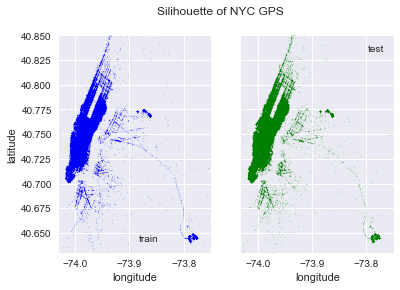

In [45]:
N = 100000
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(df_train['pickup_longitude'].values[:N], df_train['pickup_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(df_test['pickup_longitude'].values[:N], df_test['pickup_latitude'].values[:N],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Silihouette of NYC GPS')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

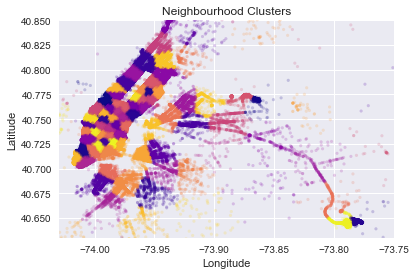

In [94]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(df_train.pickup_longitude.values[:500000], df_train.pickup_latitude.values[:500000], s=10, lw=0,
           c=df_train.pickup_cluster[:500000].values, cmap='plasma', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Neighbourhood Clusters')
plt.show()

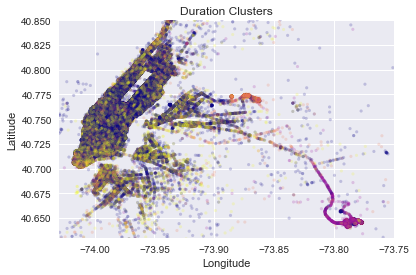

In [101]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(df_train.pickup_longitude.values[:500000], df_train.pickup_latitude.values[:500000], s=10, lw=0,
           c=df_train.duration_cluster[:500000].values, cmap='plasma', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Duration Clusters')
plt.show()

**chose not generate the silhouette reports as there are around 100 neighbourhoods in NYC according to Wikipedia**
https://en.wikipedia.org/wiki/Neighborhoods_in_New_York_City

**instead, performed elbow method and conveniently it selected k=5 as best...there are 5 boroughs in NYC!!!**

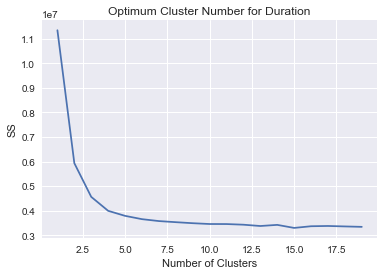

In [90]:
x =list(range(1,20))
y =[]
for k in range(1,20):
    kmeansdur = MiniBatchKMeans(n_clusters = k)
    kmeansdur.fit(coords_duration[sample_dur])
    y.append(kmeansdur.inertia_)
plt.plot(x,y)
plt.ylabel("SS")
plt.xlabel("Number of Clusters")
plt.title("Optimum Cluster Number for Duration")

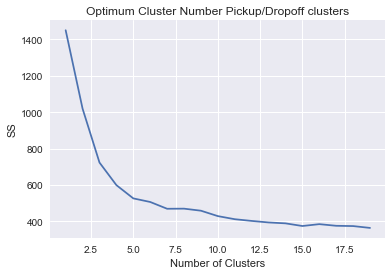

In [91]:
x =list(range(1,20))
y =[]
for k in range(1,20):
    kmeans = MiniBatchKMeans(n_clusters = k)
    kmeans.fit(coords[sample_ind])
    y.append(kmeans.inertia_)
plt.plot(x,y)
plt.ylabel("SS")
plt.xlabel("Number of Clusters")
plt.title("Optimum Cluster Number Pickup/Dropoff clusters")

# Repeat KMeans with 5 clusters & incorporate for models

In [102]:
kmeans5 = MiniBatchKMeans(n_clusters=5, batch_size=10000).fit(coords[sample_ind])

In [167]:
t0 = datetime.now()
df_train.loc[:, 'pickup_cluster'] = kmeans5.predict(df_train[['pickup_latitude', 'pickup_longitude']])
df_train.loc[:, 'dropoff_cluster'] = kmeans5.predict(df_train[['dropoff_latitude', 'dropoff_longitude']])
df_test.loc[:, 'pickup_cluster'] = kmeans5.predict(df_test[['pickup_latitude', 'pickup_longitude']])
df_test.loc[:, 'dropoff_cluster'] = kmeans5.predict(df_test[['dropoff_latitude', 'dropoff_longitude']])
t1 = datetime.now()
print('Custering Time: %i seconds' % (t1 - t0).seconds)

Custering Time: 0 seconds


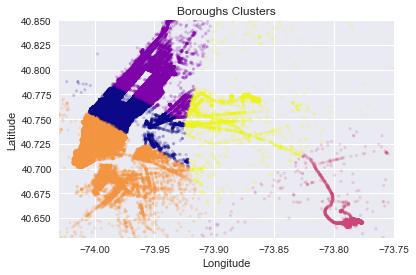

In [98]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(df_train.pickup_longitude.values[:500000], df_train.pickup_latitude.values[:500000], s=10, lw=0,
           c=df_train.pickup_cluster[:500000].values, cmap='plasma', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Boroughs Clusters')
plt.show()

In [168]:
df_test.pickup_cluster.describe()

count    625134.000000
mean          1.585617
std           1.314782
min           0.000000
25%           0.000000
50%           2.000000
75%           2.000000
max           4.000000
Name: pickup_cluster, dtype: float64

In [ ]:
cluster_pickup_train = pd.get_dummies(df_train['pickup_cluster'], prefix='p', prefix_sep='_')
#cluster_pickup_test = pd.get_dummies(df_test['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_dropoff_train = pd.get_dummies(df_train['dropoff_cluster'], prefix='d', prefix_sep='_')
#cluster_dropoff_test = pd.get_dummies(df_test['dropoff_cluster'], prefix='d', prefix_sep='_')

# Training the Model

In [105]:
X = df_train[['Month','pickup_hour','pickup_weekday','direction','total_distance','number_of_steps','distance_haversine','vendor_id','passenger_count','pickup_cluster','dropoff_cluster','duration_cluster']]
y = df_train['log_trip_duration']


In [106]:
from sklearn.model_selection import train_test_split

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

In [108]:
from sklearn.linear_model import LinearRegression

In [109]:
lm = LinearRegression()

In [110]:
lm.fit(X_train,y_train)

/Applications/anaconda/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [111]:
# The coefficients
print('Coefficients: \n', lm.coef_)

Coefficients: 
 [  1.58429701e-02   5.83587516e-03  -1.71247975e-02   1.45646824e-04
   9.11929823e-05   4.43286072e-02   7.57278462e-02   1.11873933e-02
   6.31198896e-03   3.17855033e-03   3.61438669e-02   1.76466371e-01]


## Predicting Test Data
Now that we have fit our model, let's evaluate its performance by predicting off the test values!

** Use lm.predict() to predict off the X_test set of the data.**

In [112]:
predictions = lm.predict( X_test)

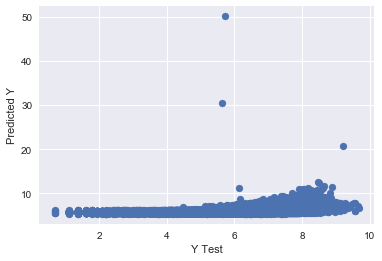

In [113]:
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

## Evaluating the Model

Let's evaluate our model performance by calculating the residual sum of squares and the explained variance score (R^2).

** Calculate the Mean Absolute Error, Mean Squared Error, and the Root Mean Squared Error. Refer to the lecture or to Wikipedia for the formulas**

In [114]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 0.387212763467
MSE: 0.282740890776
RMSE: 0.531733853329


In [115]:
print('R Squared: ', metrics.r2_score(y_test,predictions))

R Squared:  0.529135323865


## Residuals

Let's quickly explore the residuals to make sure everything was okay with our data. 

**Plot a histogram of the residuals and make sure it looks normally distributed.**

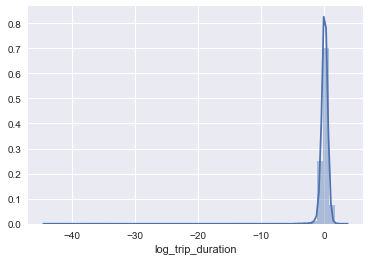

In [116]:
sns.distplot((y_test-predictions),bins=50)


## Conclusion



In [117]:
coeffecients = pd.DataFrame(lm.coef_,X.columns)
coeffecients.columns = ['Coefficient']
coeffecients.sort_values(by='Coefficient',ascending=False)

,Coefficient
duration_cluster,0.176466
distance_haversine,0.075728
number_of_steps,0.044329
dropoff_cluster,0.036144
Month,0.015843
vendor_id,0.011187
passenger_count,0.006312
pickup_hour,0.005836
pickup_cluster,0.003179
direction,0.000146


# Begin a Decision Tree Model

In [118]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456566 entries, 0 to 1458643
Data columns (total 30 columns):
id                        1456566 non-null object
vendor_id                 1456566 non-null int64
pickup_datetime           1456566 non-null datetime64[ns]
dropoff_datetime          1456566 non-null datetime64[ns]
passenger_count           1456566 non-null int64
pickup_longitude          1456566 non-null float64
pickup_latitude           1456566 non-null float64
dropoff_longitude         1456566 non-null float64
dropoff_latitude          1456566 non-null float64
store_and_fwd_flag        1456566 non-null int64
trip_duration             1456566 non-null int64
total_distance            1456566 non-null float64
total_travel_time         1456566 non-null float64
number_of_steps           1456566 non-null float64
log_trip_duration         1456566 non-null float64
pickup_date               1456566 non-null object
check_trip_duration       1456566 non-null float64
pickup_weekday  

**Create Dummy Variables for all Categorical items We want to include in model**

In [112]:
vendor_train = pd.get_dummies(df_train['vendor_id'], prefix='vi', prefix_sep='_')
passenger_count_train = pd.get_dummies(df_train['passenger_count'], prefix='pc', prefix_sep='_')
store_and_fwd_flag_train = pd.get_dummies(df_train['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
cluster_pickup_train = pd.get_dummies(df_train['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_dropoff_train = pd.get_dummies(df_train['dropoff_cluster'], prefix='d', prefix_sep='_')
month_train = pd.get_dummies(df_train['Month'], prefix='m', prefix_sep='_')
hour_train = pd.get_dummies(df_train['pickup_hour'], prefix='h', prefix_sep='_')
dow_train = pd.get_dummies(df_train['pickup_weekday'], prefix='dow', prefix_sep='_')


** Opt to use the actual values vs dummies**

In [177]:
forest_train = df_train[['log_trip_duration','distance_haversine','direction','total_distance','number_of_steps','passenger_count','Month','pickup_hour','pickup_weekday','pickup_cluster','dropoff_cluster']]


**Opt to use the dummy variables**

In [114]:
#forest_train = pd.concat([forest_train,passenger_count_train,month_train,hour_train,dow_train,cluster_pickup_train,cluster_dropoff_train],axis=1)

In [120]:
forest_train.shape

(1456566, 12)

In [125]:
#sample the original data for ease of calculation tests
forest_train_sample = forest_train.sample(frac=0.2)

In [126]:
forest_train_sample.shape

(291313, 11)

**Set up the dependent and independent matrices**

In [204]:
Xf = forest_train.drop('log_trip_duration',axis=1)
yf = forest_train['log_trip_duration']
X_train, X_test, y_train, y_test = train_test_split(Xf, yf, test_size=0.2, random_state=100)

In [122]:
#import the DT regressor
from sklearn.tree import DecisionTreeRegressor

In [179]:
#limit the depth to n-1 branches, equivalent to the degrees of freedom in the dataframe
dtree = DecisionTreeRegressor(max_depth=10)

In [180]:
dtree.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [181]:
predictions = dtree.predict(X_test)

In [182]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 0.294428846999
MSE: 0.168021342278
RMSE: 0.409904064725


In [183]:
print('R Squared: ', metrics.r2_score(y_test,predictions))

R Squared:  0.719522123588


**We Improved the Model over Linear Regression!**

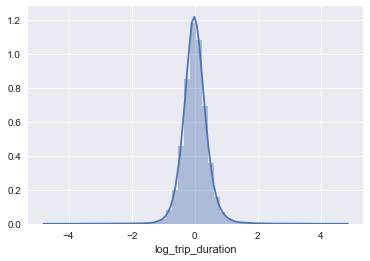

In [184]:
sns.distplot((y_test-predictions),bins=50)

In [185]:
coeffecientsDT = pd.DataFrame(dtree.feature_importances_,Xf.columns)
coeffecientsDT.columns = ['FeatureImportance']
coeffecientsDT.sort_values(by='FeatureImportance',ascending=False)

,FeatureImportance
distance_haversine,0.868791
pickup_hour,0.050771
total_distance,0.023429
direction,0.017944
pickup_weekday,0.016623
dropoff_cluster,0.010580
number_of_steps,0.005193
pickup_cluster,0.003862
passenger_count,0.001901
Month,0.000906


# Now try a RandomForestRegressor

In [131]:
from sklearn.ensemble import RandomForestRegressor

In [261]:
rfc = RandomForestRegressor(max_depth=10,n_estimators=50)

In [262]:
rfc.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [263]:
predictionsRF = rfc.predict(X_test)

In [264]:
print('MAE:', metrics.mean_absolute_error(y_test, predictionsRF))
print('MSE:', metrics.mean_squared_error(y_test, predictionsRF))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictionsRF)))

MAE: 0.288032146313
MSE: 0.161905572259
RMSE: 0.402374915047


In [265]:
print('R Squared: ', metrics.r2_score(y_test,predictionsRF))

R Squared:  0.729731173012


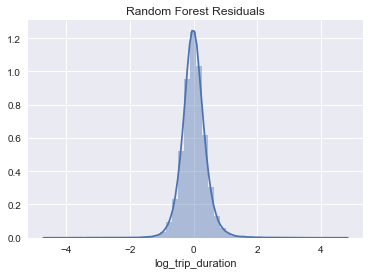

In [266]:
sns.distplot((y_test-predictionsRF),bins=50)
plt.title('Random Forest Residuals')

# only slight improvement over the DT Regressor

In [267]:
coefficientsRF = pd.DataFrame(rfc.feature_importances_,Xf.columns)
coefficientsRF.columns = ['FeatureImportance']
coefficientsRF.sort_values(by='FeatureImportance',ascending=False)


,FeatureImportance
distance_haversine,0.866087
pickup_hour,0.050771
total_distance,0.024000
direction,0.018863
pickup_weekday,0.016779
dropoff_cluster,0.011107
number_of_steps,0.005458
pickup_cluster,0.004211
passenger_count,0.001749
Month,0.000976


** The table above shows us the importance of each feature, as was evident in the Linear Model, distance of the trip is much larger magnitude than remaining variables **

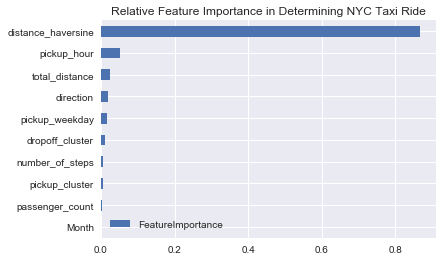

In [268]:
coefficientsRF.sort_values(by='FeatureImportance',ascending=True).plot.barh()
plt.title('Relative Feature Importance in Determining NYC Taxi Ride')

# Tweak the model with GridSearchCV

In [217]:
from sklearn.model_selection import GridSearchCV

In [246]:
# use a full grid over all parameters
param_grid = {"n_estimators": [50],
              "max_depth": [10]                                   
              }

In [247]:
# run grid search
grid_search = GridSearchCV(rfc, param_grid=param_grid)
grid_search.fit(X_train,y_train)


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [20, 50], 'max_depth': [10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [248]:
grid_search.grid_scores_

/Applications/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.73008, std: 0.00210, params: {'max_depth': 10, 'n_estimators': 20},
 mean: 0.73063, std: 0.00183, params: {'max_depth': 10, 'n_estimators': 50}]

In [249]:
grid_search.best_score_

0.73062619383880556

In [250]:
grid_search.best_params_

{'max_depth': 10, 'n_estimators': 50}

# Prepare the testing data and run the Random forest on it

In [194]:
#the difference here is that the training data contains the duration cluster, 
#test data has no trip duration values so we cannot create the same field
forest_train.shape

(1456566, 11)

In [174]:
forest_test = df_test[['distance_haversine','direction','total_distance','number_of_steps','passenger_count','Month','pickup_hour','pickup_weekday','pickup_cluster','dropoff_cluster']]

In [215]:
forest_test.shape

(625134, 10)

In [269]:
predictionsRFTest = rfc.predict(forest_test)

In [270]:
predictionsRFTest = np.exp(predictionsRFTest)-1

In [271]:
predictionsRFTest.mean()

791.29590041091785

In [200]:
Test_ID = df_test['id']

In [201]:
submission = pd.concat([Test_ID, pd.DataFrame(predictionsRFTest)], axis=1)
submission.columns = ['id','trip_duration']
submission['trip_duration'] = submission.apply(lambda x : 1 if (x['trip_duration'] <= 0) else x['trip_duration'], axis = 1)
submission.to_csv("submission.csv", index=False)